<a href="https://colab.research.google.com/github/kingtuler1454/torch/blob/main/5kab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1.   Необходимо загрузить исходный набор данных и соответствующие метки классов.
2.   Произвести разделение загруженного набора данных на обучающую, тестовую и валидационую выборки (в соотношении 80:10:10). Проверить, что сформированные выборки сбалансированы.
3.   Написать модель нейронной сети для решения задачи классификации.
4.   Описать пайплайн предобработки данных. **ВАЖНО**: что так как ваш вариант предполагает работу с текстом, то необходимо выполниить векторизацию данных (подробности в туториале).
4.   Написать `train loop` (цикл обучения). Провести эксперименты по обучению с различными значениями параметров `learning rate` (скорость обучения) и `ba
tch size` (размер мини-пакета). Выбрать по 3 значения для `learning rate` и `batch size` (итоговое количество экспериментов будет 9).
5.   Для каждого проведенного эксперимента вывести графики для значения функции потерь (ось `x` - итерация обучения/номер эпохи; ось `y` - значение функции потерь) и выбранной метрики качества (ось `x` - итерация обучения/номер эпохи; ось `y` - значение метрики качества). Графики необходимо выводить как для обучающей, так и для валидационной выборки.
6.   Оценить качество работы модели на тестовой выборке.
7.   Сделайте выводы по полученным результатам проведенных экспериментов. Какую модель из всех полученных стоит использовать?
8.   Сохранить обученную модель.
9.   Выполните повторную инициализацию модели и загрузку весов.  Продемонстрируйте работоспособность модели (пропустите через нее какой-то отзыв/рецензию и выведите результат).


https://www.kaggle.com/code/shivammehta007/spam-not-spam-classifier-with-pytorch

In [164]:
import pandas as pd
from numpy import loadtxt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
from tqdm import trange

from pymystem3 import Mystem

import nltk
from nltk.tokenize import word_tokenize
from nltk import PorterStemmer
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

import random

Описать пайплайн предобработки данных. ВАЖНО: что так как ваш вариант предполагает работу с текстом, то необходимо выполниить векторизацию данных (подробности в туториале).


In [165]:
data = pd.read_csv("dataframe.csv")

data.dropna(inplace=True)
remove_non_alphabets = lambda x: re.sub(r'[^а-яА-Я]',' ',str(x))
tokenize = lambda x: word_tokenize(x, language = "russian")

def Lemmatize(src: list):
    ''' Лемматизирует переданный датасет
    '''
    text_nomalized = ' '.join(src).lower() 

    m = Mystem()
    lemmas = m.lemmatize(text_nomalized)
    
    return lemmas

print('remove_non_alphabets')
data['text_of_comment'] = data['text_of_comment'].apply(remove_non_alphabets)

print('tokenize')
data['text_of_comment'] = data['text_of_comment'].apply(tokenize) # [ word_tokenize(row) for row in data['email']]

print('Lemmatize')
for i in data.index:
    data['text_of_comment'][i] = Lemmatize(data['text_of_comment'][i])

print('complete')
data['text_of_comment'] = data['text_of_comment'].apply(lambda x: ' '.join(x))

data.dropna(inplace=True)

print(data)
#30 minutes


remove_non_alphabets
tokenize
Lemmatize


/tmp/ipykernel_3609/2050507528.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text_of_comment'][i] = Lemmatize(data['text_of_comment'][i])


complete
      mark                                    text_of_comment
0        1  сразу   отвечать   на   вопрос   почему   я   ...
1        1  этот   сказка   хоть   и   сказка   но   учить...
2        1  несомненно   видно   мастерство   автор   кото...
3        1  этот   сказка   хоть   и   сказка   но   учить...
4        1  несомненно   видно   мастерство   автор   кото...
...    ...                                                ...
5015     5  я   казаться   что   этот   книга   должный   ...
5016     5  сильно   мощно   и   талантливо   и   глубоко ...
5017     5  ощущение   будто   посмотреть   фильм   ужас  ...
5018     5  дом   станционный   смотритель   в   одноименн...
5019     5  век   англия   в   страна   процветать   охота...

[5017 rows x 2 columns]


Произвести разделение загруженного набора данных на обучающую, тестовую и валидационую выборки (в соотношении 80:10:10). Проверить, что сформированные выборки сбалансированы.

In [167]:
#data = pd.read_csv("lemmatized.csv")
frac_seed = random.randint(0,10)
train_df = data.sample(frac=0.9, random_state=frac_seed, ignore_index=True)
valid_df = data.sample(frac=0.1, random_state=frac_seed, ignore_index=True)
for item in valid_df["text_of_comment"]:
    while item in train_df['text_of_comment']: 
        tmp = data.sample()
        item["text_of_comment"] = tmp['text_of_comment']
        item["mark"] = tmp["mark"]
    
print(data.shape)
print(train_df.shape)
print(valid_df.shape)

(5017, 2)
(4515, 2)
(502, 2)


Написать модель нейронной сети для решения задачи классификации.


In [168]:
from sklearn.model_selection import train_test_split
max_words = 10000
stopWords = stopwords.words('russian')

cv = CountVectorizer(max_features=max_words , stop_words=stopWords)

sparse_matrix = cv.fit_transform(train_df["text_of_comment"]).toarray()
valid_sparse_matrix = cv.fit_transform(valid_df["text_of_comment"]).toarray()
print(sparse_matrix.shape)
print(valid_sparse_matrix.shape)

x_val, x_test, y_val, y_test = train_test_split(
    valid_sparse_matrix, np.array(valid_df["mark"])
)

x_train, x_test, y_train, y_test = train_test_split(
    sparse_matrix, np.array(train_df["mark"]),test_size = 0.12, train_size= 0.88
)

(4515, 10000)
(502, 8200)


In [169]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear1 = nn.Linear(10000, 100)
        self.linear2 = nn.Linear(100, 10)
        self.linear3 = nn.Linear(10, 6)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x


#model = LogisticRegression()
#criterion = nn.CrossEntropyLoss()

x_train = Variable(torch.from_numpy(x_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()

Написать train loop (цикл обучения). Провести эксперименты по обучению с различными значениями параметров learning rate (скорость обучения) и ba tch size (размер мини-пакета). Выбрать по 3 значения для learning rate и batch size (итоговое количество экспериментов будет 9).

Для каждого проведенного эксперимента вывести графики для значения функции потерь (ось x - итерация обучения/номер эпохи; ось y - значение функции потерь) и выбранной метрики качества (ось x - итерация обучения/номер эпохи; ось y - значение метрики качества). 

/tmp/ipykernel_3609/2115783627.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["text_of_comment"][i] = [elem for elem in data["text_of_comment"][i] if elem!=' ']


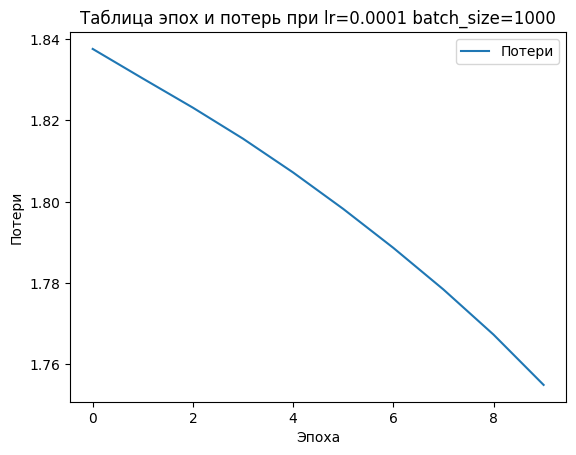

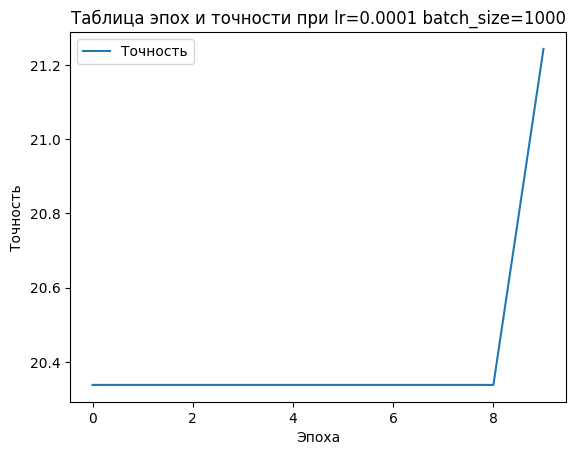

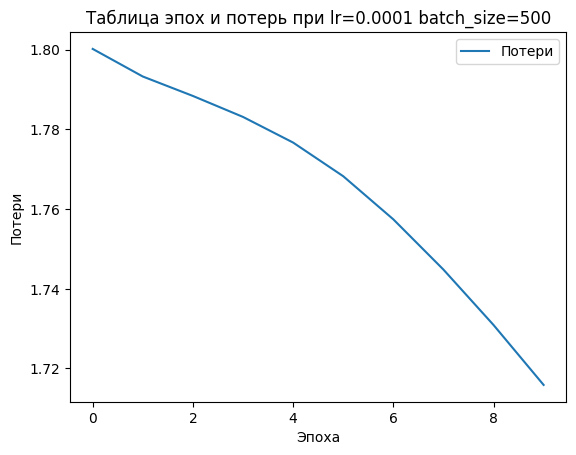

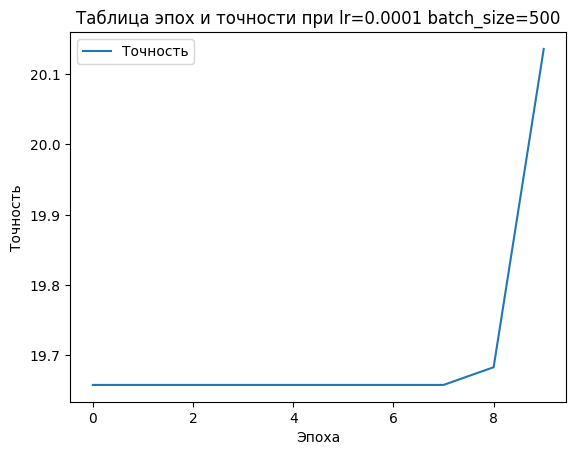

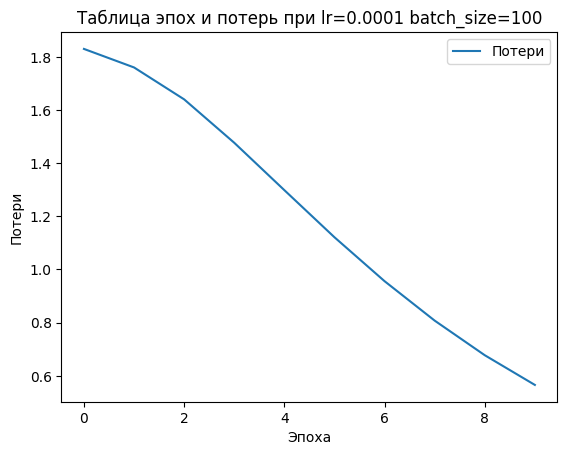

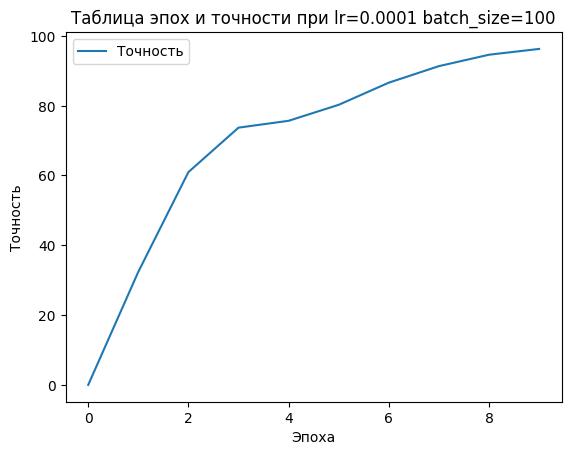

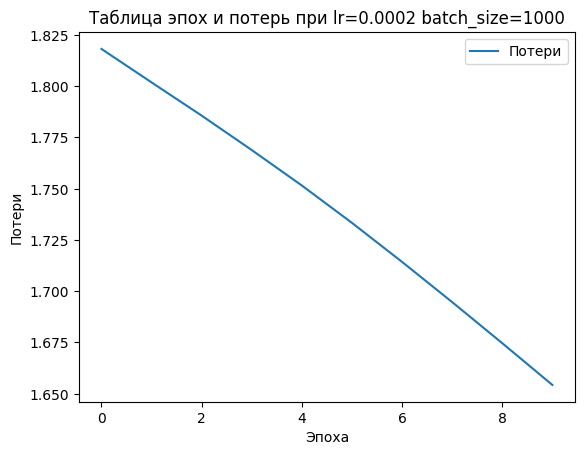

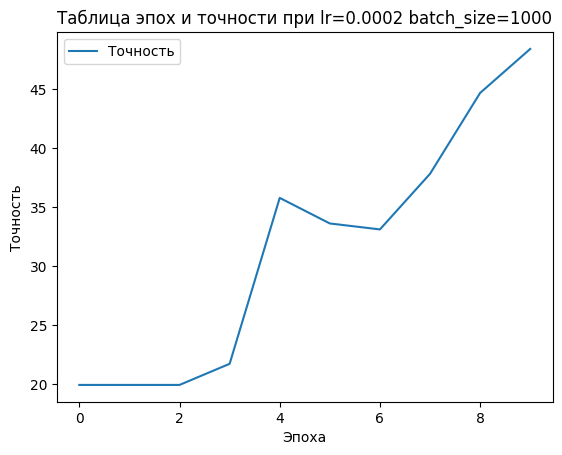

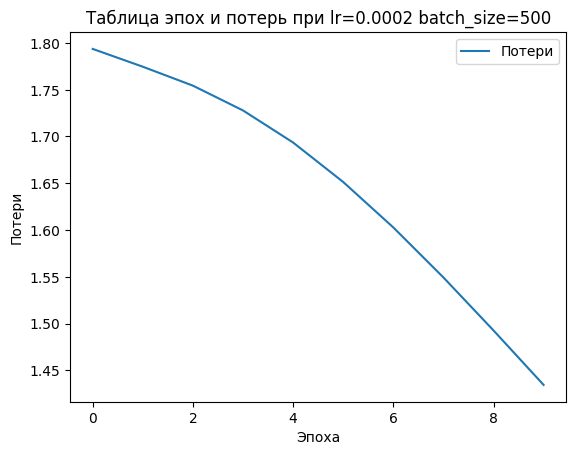

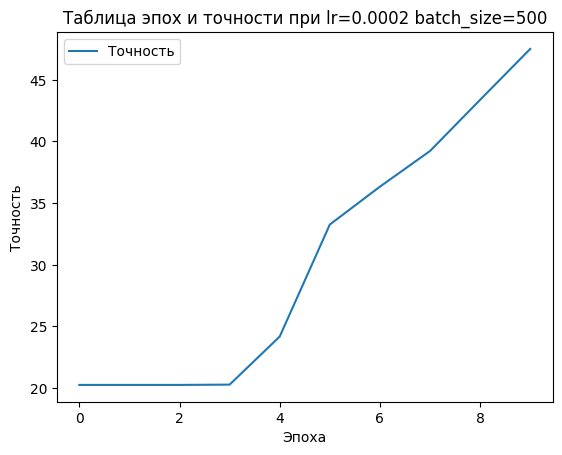

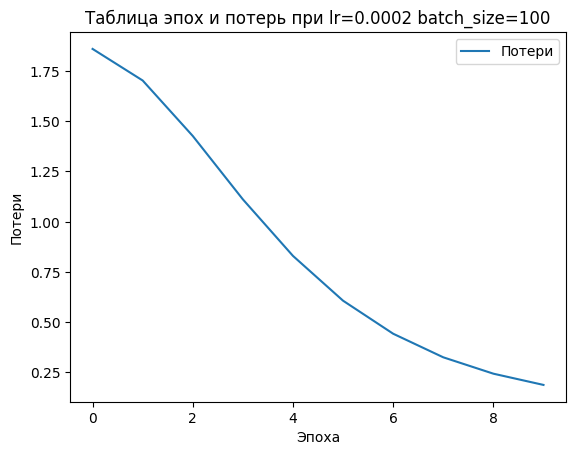

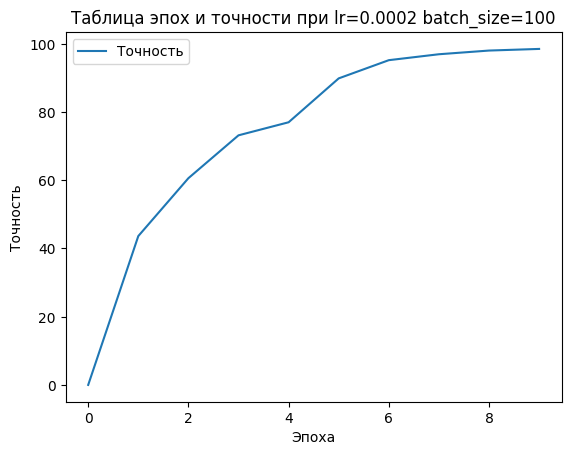

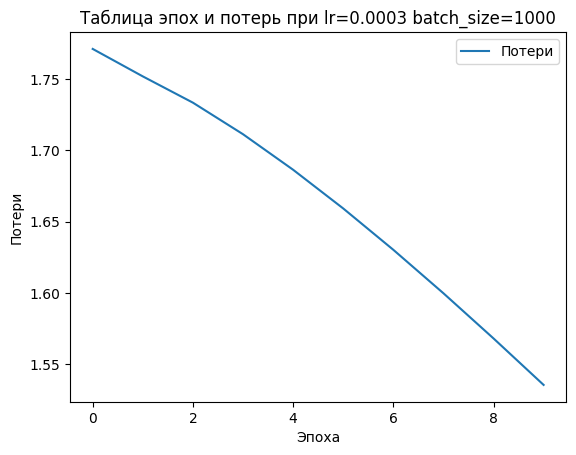

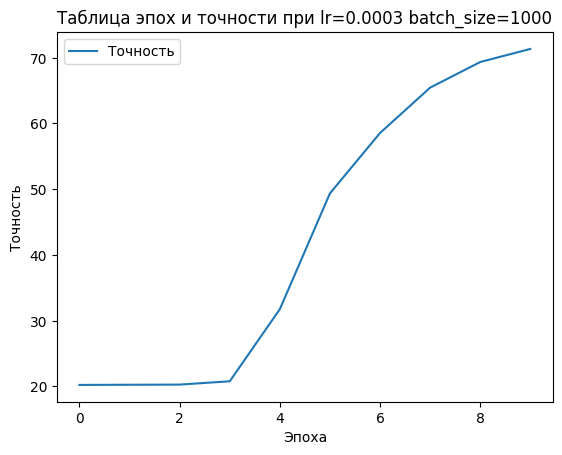

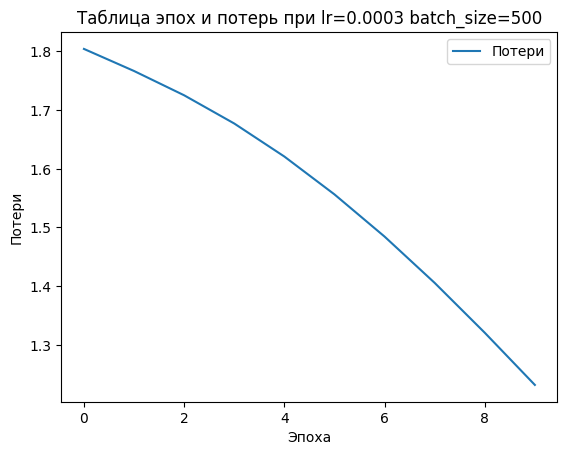

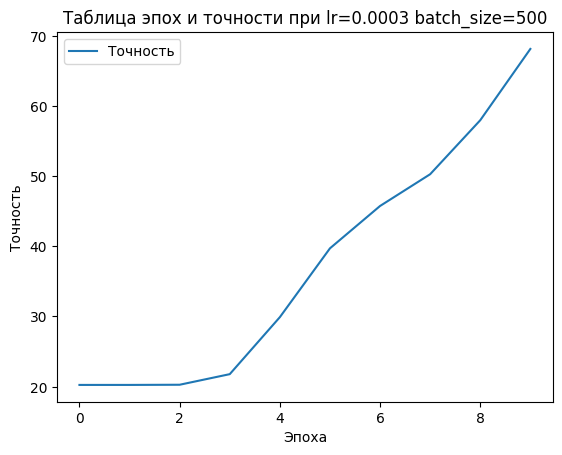

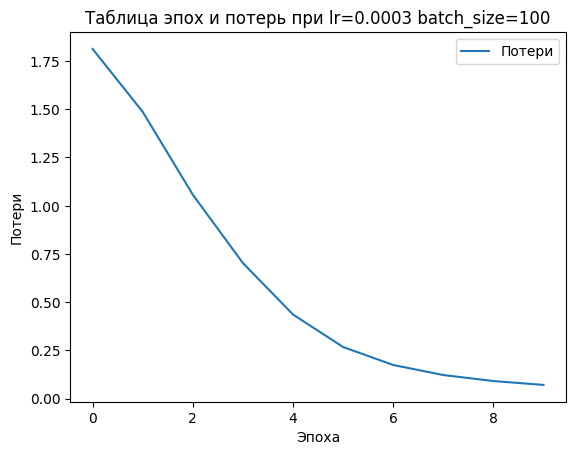

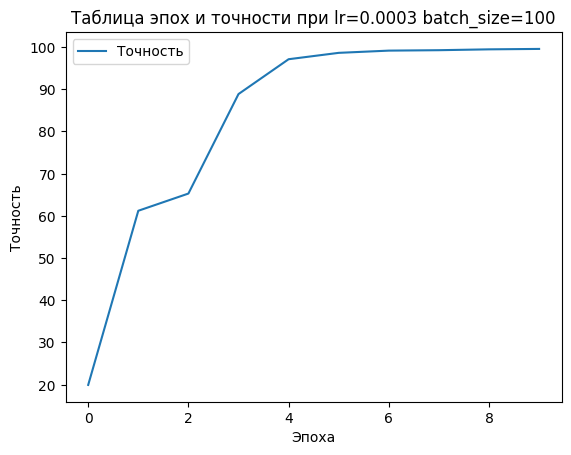

In [170]:
def expirement(lr, batch_size):
    model = LogisticRegression()
    criterion = nn.CrossEntropyLoss()
    
    data = torch.utils.data.DataLoader(x_train, batch_size = batch_size)
    optimizer = torch.optim.Adam(params=model.parameters() , lr = lr)
    epochs = 10
    model.train()
    loss_values = []
    acc_values = list()
    
    for epoch in range(epochs):
        for elems in data: 
            
            optimizer.zero_grad()
            
            y_pred = model(x_train)
            
            
            loss = criterion(y_pred, y_train)
            loss_values.append(loss.item())
            pred = torch.max(y_pred, 1)[1].eq(y_train).sum()
            acc = pred * 100.0 / len(x_train)
            acc_values.append(acc)
            loss.backward()
            optimizer.step()
    
    epochs_values = list()
    for i in range(0,epochs): epochs_values.append(i)
    
    loss_values_graph = list()
    
    for i in range(0,len(loss_values), len(loss_values)//epochs):
        loss_values_graph.append(loss_values[i])
        
    acc_values_graph = list()
    
    for i in range(0,len(acc_values), len(acc_values)//epochs):
        acc_values_graph.append(acc_values[i])
        
    #print(loss_values_graph, epochs_values)
    
    plt.plot(epochs_values, loss_values_graph)
    plt.title('Таблица эпох и потерь при lr='+str(lr) +" batch_size="+str(batch_size))
    plt.xlabel('Эпоха',)
    plt.ylabel('Потери')
    plt.legend(['Потери'])
    plt.show()
    
    plt.plot(epochs_values, acc_values_graph)
    plt.title('Таблица эпох и точности при lr='+str(lr) +" batch_size="+str(batch_size))
    plt.xlabel('Эпоха',)
    plt.ylabel('Точность')
    plt.legend(['Точность'])
    plt.show()
    
    return model
    
if True:
    for i in data.index:
        data["text_of_comment"][i] = [elem for elem in data["text_of_comment"][i] if elem!=' ']
        
    data.to_csv("lemmatized.csv")
    
    my_models = list()
    lr_list=[0.0001,0.0002,0.0003]
    batch_size=[1000,500,100]

    for LR in lr_list:
            for BZ in batch_size:
                my_models.append(expirement(LR,BZ))

Оценить качество работы модели на тестовой выборке.

In [171]:
for model in my_models:  
    criterion = nn.CrossEntropyLoss()  
    x_test = torch.Tensor(x_test).float()
    y_test=[int(i) for i in y_test]
    y_test = torch.Tensor(y_test).long()
    model.eval()
    with torch.no_grad():
        for i in range(20):
            y_pred = model(x_test)
            loss = criterion(y_pred, y_test)
            pred = torch.max(y_pred, 1)[1].eq(y_test).sum()
        print ("Accuracy : {}%".format(100*pred/len(x_test)))

Accuracy : 18.081180572509766%
Accuracy : 19.55719566345215%
Accuracy : 32.10332107543945%
Accuracy : 32.47232437133789%
Accuracy : 26.199262619018555%
Accuracy : 32.28782272338867%
Accuracy : 28.413284301757812%
Accuracy : 31.365314483642578%
Accuracy : 30.62730598449707%


Сделайте выводы по полученным результатам проведенных экспериментов. Какую модель из всех полученных стоит использовать?

In [172]:
LR = 0.0003
BZ = 100

Сохранить обученную модель.

In [173]:
i = 0
for model in my_models:
    torch.save(model.state_dict(), os.path.join("./", f"weight{i}.pt"))
    i+=1

Выполните повторную инициализацию модели и загрузку весов. Продемонстрируйте работоспособность модели (пропустите через нее какой-то отзыв/рецензию и выведите результат).

In [174]:
j = 0
for model in my_models:
    model.load_state_dict(torch.load(os.path.join("./", f"weight{j}.pt")))
    data=torch.utils.data.DataLoader(x_test, batch_size=BZ,shuffle=True)
    model.eval()
    text_list=[]
    with torch.no_grad():
        for i in range(20):
            y_pred = model(x_test)
            loss = criterion(y_pred, y_test)
            pred = torch.max(y_pred, 1)[1].eq(y_test).sum()
        print ("Accuracy : {}%".format(100*pred/len(x_test)))
    j+=1

Accuracy : 18.081180572509766%
Accuracy : 19.55719566345215%
Accuracy : 32.10332107543945%
Accuracy : 32.47232437133789%
Accuracy : 26.199262619018555%
Accuracy : 32.28782272338867%
Accuracy : 28.413284301757812%
Accuracy : 31.365314483642578%
Accuracy : 30.62730598449707%
